In [1]:
dataname="CVS"
ignore_index = -100 #Unet has the possibility of masking out pixels in the output image, we can specify the index value here (though not used)
gpuid= 0

# --- unet params
#these parameters get fed directly into the UNET class, and more description of them can be discovered there
n_classes= 2    #number of classes in the data mask that we'll aim to predict
backbone = 'resnet50'

# --- training params
patch_size=224
batch_size=32
num_epochs = 250
phases = ["train","val"]
validation_phases= ["val"] #when should we do valiation, do it only for vlaidation at the end of the epoch

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from skimage.transform import rescale, resize, downscale_local_mean
from backboned_unet import Unet
from utils import iou
import os

import PIL
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

import numpy as np
import sys, glob

from tensorboardX import SummaryWriter

import scipy.ndimage 

import time
import math
#import tables

import random

from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [3]:
#helper function for pretty printing of current time and remaining time
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent+.00001)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [4]:
#specify if we should use a GPU (cuda) or only the CPU
if(torch.cuda.is_available()):
    print(torch.cuda.get_device_properties(gpuid))
    torch.cuda.set_device(gpuid)
    device = torch.device(f'cuda:{gpuid}')
else:
    device = torch.device(f'cpu')

_CudaDeviceProperties(name='GeForce RTX 3090', major=8, minor=6, total_memory=24245MB, multi_processor_count=82)


In [5]:
#build the model according to the paramters specified above and copy it to the GPU. finally print out the number of trainable parameters
model = Unet(backbone_name=backbone,pretrained=True,classes=n_classes).to(device)
print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}")

upsample_blocks[0] in: 2048   out: 256
upsample_blocks[1] in: 256   out: 128
upsample_blocks[2] in: 128   out: 64
upsample_blocks[3] in: 64   out: 32
upsample_blocks[4] in: 32   out: 16
total params: 	38544650


In [6]:
class Dataset(object):
    def __init__(self, fname, img_path, mask_path, img_transform=None, mask_transform = None, edge_weight= False):
        
        self.fname=fname
        self.mask_path = mask_path
        self.img_path = img_path
        self.edge_weight = edge_weight
        
        self.img_transform=img_transform
        self.mask_transform = mask_transform
        
        infile = open(self.fname,'r')
        self.img_lines = infile.readlines()
        self.img_lines = [line.strip() for line in self.img_lines]
        infile.close()
        self.nitems = len(self.img_lines)
        
    def __getitem__(self, index):
        img = plt.imread(os.path.join(self.img_path,self.img_lines[index]+'.jpeg'))
        mask = np.load(os.path.join(self.mask_path,self.img_lines[index]+'.npy'))
        mask = mask.astype('uint8')
        
        mask = mask[:,:,None].repeat(3,axis=2) #in order to use the transformations given by torchvision
        
        img_new = img
        mask_new = mask

        
        seed = random.randrange(sys.maxsize) #get a random seed so that we can reproducibly do the transofrmations
        if self.img_transform is not None:
            random.seed(seed) # apply this seed to img transforms
            img_new = self.img_transform(img)

        if self.mask_transform is not None:
            random.seed(seed) 
            mask_new = self.mask_transform(mask)
            mask_new = np.asarray(mask_new)[:,:,0].squeeze()#[:,:,0:1]
            random.seed(seed)

        return img_new, mask_new
    
    def __len__(self):
        return self.nitems

In [7]:
#note that since we need the transofrmations to be reproducible for both masks and images
#we do the spatial transformations first, and afterwards do any color augmentations
img_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((patch_size,patch_size)),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=(patch_size,patch_size),pad_if_needed=True), #these need to be in a reproducible order, first affine transforms and then color
    transforms.RandomResizedCrop(size=patch_size),
    transforms.RandomRotation(180),
    transforms.ColorJitter(brightness=0.6, contrast=0, saturation=0, hue=0),
    transforms.RandomGrayscale(),
    transforms.ToTensor()
    ])


mask_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((patch_size,patch_size)),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=(patch_size,patch_size),pad_if_needed=True), #these need to be in a reproducible order, first affine transforms and then color
    transforms.RandomResizedCrop(size=patch_size,interpolation=PIL.Image.NEAREST),
    transforms.RandomRotation(180),
    ])



dataset={}
dataLoader={}
for phase in phases: 
    dataset[phase]=Dataset(f"./{phase}.txt",f"./raw",f"./mask", img_transform=img_transform, mask_transform = mask_transform)
    dataLoader[phase]=DataLoader(dataset[phase], batch_size=batch_size, 
                                shuffle=True, num_workers=16, pin_memory=True) 

(224, 224)

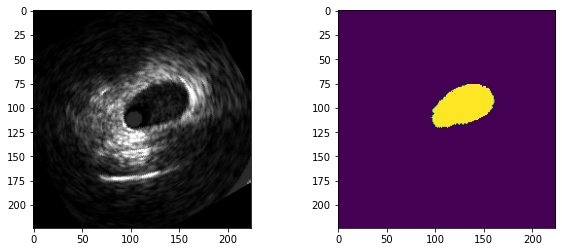

In [8]:
#visualize a single example to verify that it is correct
(img,patch_mask)=dataset["train"][7]
fig, ax = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns

#build output showing original patch  (after augmentation), class = 1 mask, weighting mask, overall mask (to see any ignored classes)
ax[0].imshow(np.moveaxis(img.numpy(),0,-1))
ax[1].imshow(patch_mask)
patch_mask.shape

In [9]:
#optim = torch.optim.Adam(model.parameters())
optim = torch.optim.RMSprop(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index = ignore_index, reduce = False)#nn.CrossEntropyLoss(weight = torch.tensor([1., 3.]).to(device), ignore_index=ignore_index, reduce=False) #reduce = False makes sure we get a 2D output instead of a 1D "summary" value

In [10]:
writer=SummaryWriter() #open the tensorboard visualiser
best_loss_on_test = np.Infinity
start_time = time.time()
for epoch in range(num_epochs):
    #zero out epoch based performance variables 
    all_acc = {key: 0 for key in phases} 
    all_loss = {key: torch.zeros(0).to(device) for key in phases}
    cmatrix = {key: np.zeros((2,2)) for key in phases}

    for phase in phases: #iterate through both training and validation states

        if phase == 'train':
            model.train()  # Set model to training mode
        else: #when in eval mode, we don't want parameters to be updated
            model.eval()   # Set model to evaluate mode

        for ii , (X, y) in enumerate(dataLoader[phase]): #for each of the batches
            X = X.to(device)  # [Nbatch, 3, H, W]
            y = y.type('torch.LongTensor').to(device)  # [Nbatch, H, W] with class indices (0, 1)
            with torch.set_grad_enabled(phase == 'train'): #dynamically set gradient computation, in case of validation, this isn't needed
                                                           #disabling is good practice and improves inference time
                prediction = model(X)  # [N, Nclass, H, W]
                loss_matrix = criterion(prediction, y)
                loss = loss_matrix.mean()
            
                if phase=="train": #in case we're in train mode, need to do back propogation
                    optim.zero_grad()
                    loss.backward()
                    optim.step()
                    train_loss = loss
                    


                all_loss[phase]=torch.cat((all_loss[phase],loss.detach().view(1,-1)))

                if phase in validation_phases: #if this phase is part of validation, compute confusion matrix
                    p=prediction[:,:,:,:].detach().cpu().numpy()
                    cpredflat=np.argmax(p,axis=1).flatten()
                    yflat=y.cpu().numpy().flatten()

                    cmatrix[phase]=cmatrix[phase]+confusion_matrix(yflat,cpredflat,labels=range(n_classes))

        all_acc[phase]=(cmatrix[phase]/cmatrix[phase].sum()).trace()
        all_loss[phase] = all_loss[phase].cpu().numpy().mean()
        
        #save metrics to tensorboard
        writer.add_scalar(f'{phase}/loss', all_loss[phase], epoch)
        if phase in validation_phases:
            writer.add_scalar(f'{phase}/acc', all_acc[phase], epoch)
            writer.add_scalar(f'{phase}/TN', cmatrix[phase][0,0], epoch)
            writer.add_scalar(f'{phase}/TP', cmatrix[phase][1,1], epoch)
            writer.add_scalar(f'{phase}/FP', cmatrix[phase][0,1], epoch)
            writer.add_scalar(f'{phase}/FN', cmatrix[phase][1,0], epoch)
            writer.add_scalar(f'{phase}/TNR', cmatrix[phase][0,0]/(cmatrix[phase][0,0]+cmatrix[phase][0,1]), epoch)
            writer.add_scalar(f'{phase}/TPR', cmatrix[phase][1,1]/(cmatrix[phase][1,1]+cmatrix[phase][1,0]), epoch)
        

    print('%s ([%d/%d] %d%%), train loss: %.4f test loss: %.4f' % (timeSince(start_time, (epoch+1) / num_epochs), 
                                                 epoch+1, num_epochs ,(epoch+1) / num_epochs * 100, all_loss["train"], all_loss["val"]),end="")    

    #if current loss is the best we've seen, save model state with all variables
    #necessary for recreation
    if all_loss["val"] < best_loss_on_test:
        best_loss_on_test = all_loss["val"]
        print("  **")
        state = {'epoch': epoch + 1,
         'model_dict': model.state_dict(),
         'optim_dict': optim.state_dict(),
         'best_loss_on_test': all_loss,
         'n_classes': n_classes,}


        torch.save(state, f"{dataname}_backboned_unet_{backbone}_best_model.pt")
    else:
        print("")

0m 4s (- 16m 36s) ([1/250] 0%), train loss: 0.6153 test loss: 3.9487  **
0m 8s (- 16m 50s) ([2/250] 0%), train loss: 0.5293 test loss: 0.5775  **
0m 12s (- 16m 47s) ([3/250] 1%), train loss: 0.5240 test loss: 0.7490
0m 15s (- 16m 21s) ([4/250] 1%), train loss: 0.4923 test loss: 0.5993
0m 19s (- 16m 1s) ([5/250] 2%), train loss: 0.4743 test loss: 0.6571
0m 23s (- 15m 49s) ([6/250] 2%), train loss: 0.4579 test loss: 0.5026  **
0m 27s (- 15m 52s) ([7/250] 2%), train loss: 0.4175 test loss: 0.8935
0m 31s (- 15m 41s) ([8/250] 3%), train loss: 0.4146 test loss: 0.5445
0m 34s (- 15m 33s) ([9/250] 3%), train loss: 0.3711 test loss: 0.5026  **
0m 38s (- 15m 33s) ([10/250] 4%), train loss: 0.3484 test loss: 0.5408
0m 42s (- 15m 26s) ([11/250] 4%), train loss: 0.3231 test loss: 0.4146  **
0m 46s (- 15m 25s) ([12/250] 4%), train loss: 0.3209 test loss: 0.5624
0m 50s (- 15m 18s) ([13/250] 5%), train loss: 0.2987 test loss: 2.0601
0m 54s (- 15m 10s) ([14/250] 5%), train loss: 0.3084 test loss: 0.429

7m 21s (- 8m 38s) ([115/250] 46%), train loss: 0.1536 test loss: 0.2174
7m 25s (- 8m 34s) ([116/250] 46%), train loss: 0.1670 test loss: 0.4470
7m 29s (- 8m 30s) ([117/250] 46%), train loss: 0.1813 test loss: 0.2255
7m 33s (- 8m 26s) ([118/250] 47%), train loss: 0.1623 test loss: 0.2353
7m 36s (- 8m 22s) ([119/250] 47%), train loss: 0.1524 test loss: 0.1617
7m 40s (- 8m 18s) ([120/250] 48%), train loss: 0.1376 test loss: 0.1409
7m 44s (- 8m 15s) ([121/250] 48%), train loss: 0.1580 test loss: 0.1754
7m 48s (- 8m 11s) ([122/250] 48%), train loss: 0.1450 test loss: 0.1860
7m 52s (- 8m 7s) ([123/250] 49%), train loss: 0.1665 test loss: 0.1387
7m 56s (- 8m 3s) ([124/250] 49%), train loss: 0.1544 test loss: 0.2385
8m 0s (- 8m 0s) ([125/250] 50%), train loss: 0.1460 test loss: 0.2404
8m 3s (- 7m 56s) ([126/250] 50%), train loss: 0.1324 test loss: 0.1399
8m 7s (- 7m 52s) ([127/250] 50%), train loss: 0.1515 test loss: 0.2547
8m 11s (- 7m 48s) ([128/250] 51%), train loss: 0.1726 test loss: 0.429

KeyboardInterrupt: 